In [27]:
#130713

# Course Work 1

## Exercise 2

In this exercise, you will implement the Naive-Bayes algorithm for classification. Please read the instructions in the pdf provided in e-class.

In [28]:
# Here your ID:
import numpy as np
import matplotlib.pyplot as plt #can be reeplaced by other libraries
import pandas as pd
#is not allowed to use libraries besides the ones here besides reeplacing matplotlib

In [29]:
class NaiveBayesClassifier:
    """
    Classificador Naïve Bayes
    """

    def __init__(self, smoothing=1e-9):
        """
        Inicializa o classificador

        Args:
            smoothing: valor pequeno para evitar divisão por zero
        """
        self.smoothing = smoothing
        self.classes = None
        self.class_priors = {}
        self.feature_means = {}
        self.feature_stds = {}
        self.fitted = False

    def fit(self, X, y):
        """
        Treina o modelo com os dados fornecidos

        Args:
            X: DataFrame ou array com as features
            y: Series ou array com os labels
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.classes = np.unique(y)
        n_samples = len(y)

        # Calcula probabilidades a priori das classes
        for class_val in self.classes:
            class_mask = (y == class_val)
            self.class_priors[class_val] = np.sum(class_mask) / n_samples

            # Calcula média e desvio padrão para cada feature por classe
            X_class = X[class_mask]
            self.feature_means[class_val] = np.mean(X_class, axis=0)
            self.feature_stds[class_val] = np.std(X_class, axis=0) + self.smoothing

        self.fitted = True
        return self

    def _gaussian_pdf(self, x, mean, std):
        """
        Calcula a densidade de probabilidade gaussiana
        """
        exponent = -0.5 * ((x - mean) / std) ** 2
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exponent)

    def predict_proba(self, X):
        """
        Prediz as probabilidades das classes

        Args:
            X: DataFrame ou array com as features

        Returns:
            Array com probabilidades para cada classe
        """
        if not self.fitted:
            raise ValueError("Modelo não foi treinado ainda!")

        if isinstance(X, pd.DataFrame):
            X = X.values

        n_samples = X.shape[0]
        probabilities = np.zeros((n_samples, len(self.classes)))

        for i, class_val in enumerate(self.classes):
            # Probabilidade a priori
            class_prob = np.log(self.class_priors[class_val])

            # Probabilidade das features dada a classe
            for j in range(X.shape[1]):
                feature_prob = self._gaussian_pdf(
                    X[:, j],
                    self.feature_means[class_val][j],
                    self.feature_stds[class_val][j]
                )
                class_prob += np.log(feature_prob + self.smoothing)

            probabilities[:, i] = class_prob

        # Normaliza as probabilidades (softmax)
        probabilities = probabilities - np.max(probabilities, axis=1, keepdims=True)
        probabilities = np.exp(probabilities)
        probabilities = probabilities / np.sum(probabilities, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """
        Prediz as classes

        Args:
            X: DataFrame ou array com as features

        Returns:
            Array com as predições
        """
        probabilities = self.predict_proba(X)
        return self.classes[np.argmax(probabilities, axis=1)]


In [30]:
def train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    """Simple train-test split implementation"""
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(X)
    n_test = int(n_samples * test_size)

    if stratify is not None:
        # Stratified split
        unique_classes = np.unique(stratify)
        train_indices = []
        test_indices = []

        for class_label in unique_classes:
            class_indices = np.where(stratify == class_label)[0]
            n_class_test = int(len(class_indices) * test_size)

            np.random.shuffle(class_indices)
            test_indices.extend(class_indices[:n_class_test])
            train_indices.extend(class_indices[n_class_test:])

        train_indices = np.array(train_indices)
        test_indices = np.array(test_indices)
    else:
        # Random split
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def accuracy_score(y_true, y_pred):
    """Calculate accuracy score"""
    return np.mean(y_true == y_pred)


def precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0):
    """Calculate precision, recall, f1-score and support"""
    classes = np.unique(y_true)
    n_classes = len(classes)

    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    support = np.zeros(n_classes)

    for i, class_label in enumerate(classes):
        # True positives, false positives, false negatives
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        fp = np.sum((y_true != class_label) & (y_pred == class_label))
        fn = np.sum((y_true == class_label) & (y_pred != class_label))

        # Precision
        if tp + fp == 0:
            precision[i] = zero_division
        else:
            precision[i] = tp / (tp + fp)

        # Recall
        if tp + fn == 0:
            recall[i] = zero_division
        else:
            recall[i] = tp / (tp + fn)

        # F1-score
        if precision[i] + recall[i] == 0:
            f1[i] = zero_division
        else:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

        # Support
        support[i] = np.sum(y_true == class_label)

    return precision, recall, f1, support.astype(int)

def evaluate_model(y_true, y_pred, class_names=None):
    """Evaluate model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    print(f"\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nPer-class metrics:")

    classes = np.unique(y_true)
    for i, class_label in enumerate(classes):
        class_name = f"Class {class_label}" if class_names is None else class_names[i]
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")

    return accuracy, precision, recall, f1

In [31]:
# Carrega os dados
data = pd.read_csv("diabetes.csv")
print(f"Dados carregados com sucesso: {data.shape}")
print(f"Colunas: {list(data.columns)}")
print(f"\nDistribuição das classes:")
print(data.iloc[:, -1].value_counts())

# Separa features e target
X = data.iloc[:, :-1].values  # (features)
y = data.iloc[:, -1].values   # (target)

# Treino, validação e teste

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"\nDivisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Validação: {X_val.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

Dados carregados com sucesso: (768, 9)
Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Distribuição das classes:
Outcome
0    500
1    268
Name: count, dtype: int64

Divisão dos dados:
Treino: 523 amostras
Validação: 130 amostras
Teste: 115 amostras


In [32]:
# Busca de hiperparâmetros
smoothing_values = [1e-10, 1e-5, 1e-3, 1e-2, 1e-1, 0.1, 1.0, ]
best_accuracy = 0
best_smoothing = None
validation_results = []

for smoothing in smoothing_values:
    model = NaiveBayesClassifier(smoothing=smoothing)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)

    validation_results.append({
        'smoothing': smoothing,
        'accuracy': accuracy
    })

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_smoothing = smoothing

    print(f"Smoothing: {smoothing:.1e}, Accuracy: {accuracy:.4f}")

print(f"\nMelhor smoothing: {best_smoothing:.1e}")
print(f"Melhor accuracy na validação: {best_accuracy:.4f}")

Smoothing: 1.0e-10, Accuracy: 0.7692
Smoothing: 1.0e-05, Accuracy: 0.7692
Smoothing: 1.0e-03, Accuracy: 0.7538
Smoothing: 1.0e-02, Accuracy: 0.7231
Smoothing: 1.0e-01, Accuracy: 0.6538
Smoothing: 1.0e-01, Accuracy: 0.6538
Smoothing: 1.0e+00, Accuracy: 0.6538

Melhor smoothing: 1.0e-10
Melhor accuracy na validação: 0.7692


In [33]:

# Junta os dados de treino e validação
X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

# Modelo final
final_model = NaiveBayesClassifier(smoothing=best_smoothing)
final_model.fit(X_train, y_train)

# Predição
y_pred_test = final_model.predict(X_test)

# Usar as funções de avaliação
class_names = ["Não Diabético", "Diabético"]
accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred_test, class_names)


Model Evaluation:
Accuracy: 0.8174

Per-class metrics:
Não Diabético:
  Precision: 0.8214
  Recall: 0.9200
  F1-score: 0.8679
  Support: 75
Diabético:
  Precision: 0.8065
  Recall: 0.6250
  F1-score: 0.7042
  Support: 40


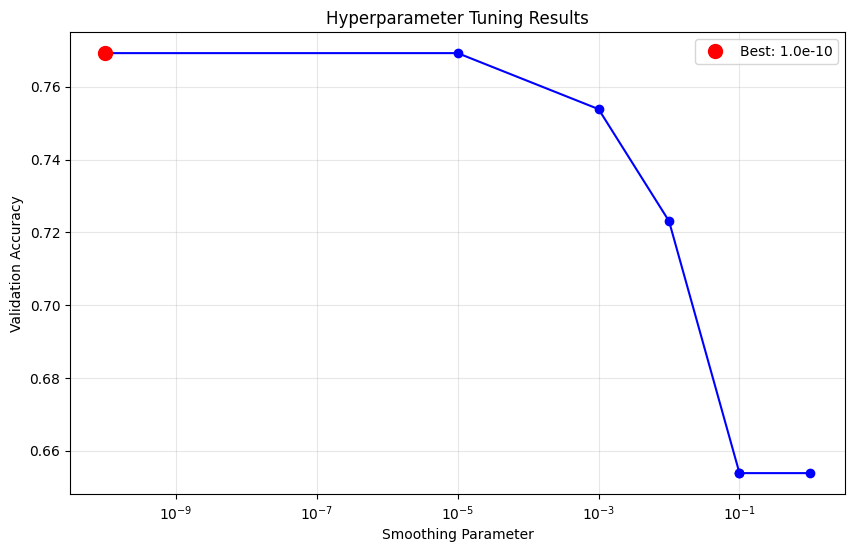

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Gráfico de ajuste de hiperparâmetros
smoothing_vals = [r['smoothing'] for r in validation_results]
accuracies = [r['accuracy'] for r in validation_results]

ax1.semilogx(smoothing_vals, accuracies, 'bo-')
ax1.set_xlabel('Smoothing Parameter')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Hyperparameter Tuning Results')
ax1.grid(True, alpha=0.3)

# Marcar o melhor valor
best_idx = np.argmax(accuracies)
ax1.plot(smoothing_vals[best_idx], accuracies[best_idx], 'ro', markersize=10,
                 label=f'Best: {smoothing_vals[best_idx]:.1e}')
ax1.legend()

plt.show()
